# Notebook for a NN regression model for CMAPSS dataset

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Import all relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = './data/train_FD001.txt'

# Set the column names for the raw CMAPSS data
columns = ['machine_number', 'uptime', 'setting_1', 'setting_2', 'setting_3']
sensor_measurements = [f'sensor_{i:02d}' for i in range(1, 25)]
columns += sensor_measurements

# Read plain text file
df = pd.read_csv(filename, sep=" ", names=columns, index_col=False)

# Drop dummy columns
df.drop(columns=['sensor_22', 'sensor_23', 'sensor_24'], inplace=True)

In [3]:
# Use the profiler to remove constant values
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
# profile.to_file("FD001.html")

In [123]:
# Get list of rejected variables due to constant values
rejected_features = list(profile.get_rejected_variables())
# Remove sensor_06 which is also constant. Comes from viewing the data.
rejected_features += ['setting_1', 'setting_2', 'sensor_06']

In [5]:
def reference_df_builder(df):
    # Reference function
    return (df
            .assign(sensor_12_13=lambda d: d['sensor_12'] + d['sensor_13'])
           )

In [124]:
rejected_features

['setting_3',
 'sensor_01',
 'sensor_18',
 'sensor_05',
 'sensor_19',
 'sensor_16',
 'sensor_10',
 'setting_1',
 'setting_2',
 'sensor_06']

In [127]:
def add_train_RUL(grp):
    # Apply clipping to RUL based on uptime
    grp['RUL'] = (grp['uptime'].max() - grp['uptime'] + 1)
    # Apply clipping to RUL
    grp['RUL'].clip(upper=125, inplace=True)
    return grp

def add_test_RUL(grp):
    grp['RUL'] += grp['uptime'].max() - grp['uptime']
    # Apply clipping to RUL
    grp['RUL'].clip(upper=125, inplace=True)
    return grp

def add_lags(grp_, lag=1):
    grp = grp_.copy()
    # Remove columns that are not meant to be lagged
    cols = grp.columns.difference(['machine_number', 'uptime', 'RUL'])
    # Loop over each feature and lag value
    for col in cols:
        for i in range(1, lag+1):
            grp[f'{col}_tm{i:02}'] = grp[f'{col}'].shift(i)
    return grp

def clean_dataf(df):
    return (df
             .drop(columns=rejected_features)
             .sort_values(by=['machine_number', 'uptime'], axis=0)
             .groupby('machine_number')
             .apply(add_train_RUL)
             # .groupby('machine_number')
             # .apply(add_lags, (num_lags))
             # .dropna()
            )

def clean_dataf_test(df):
    return (df
             .drop(columns=rejected_features)
             .sort_values(['machine_number', 'uptime'], axis=0)
             .groupby('machine_number')
             .apply(add_test_RUL)
             # .groupby('machine_number')
             # .apply(add_lags, (num_lags))
             # .dropna()
            )

In [128]:
def add_lagged_vars(df, num_lags, columns_not_lagged):
    ''' Takes a time-series dataframe and appends lagged variables using DataFrame.shift() . '''
    
    # take a copy of the dataframe
    df_copy = df.copy() 
    
    # drop the columns that are not to be lagged
    for column in columns_not_lagged:
        df_copy.drop(column, inplace=True, axis=1)
    
    # get list of shifted dataframes
    shifted_dfs = []
    for i in range(1, num_lags+1):
        shifted_df = df_copy.shift(i)
        shifted_df.columns = [f'{name}_tm{i:02}' for name in df_copy.columns]
        shifted_dfs.append(shifted_df)
        
    # concatenate all the shifted dfs horizontally
    new_df = pd.concat(shifted_dfs, axis=1)

    # now join the original df to the new df
    final_df = pd.concat([df, new_df], axis=1)
    
    # drop rows with nans created from shifting and reset the index
    final_df.dropna(inplace=True)
    final_df.reset_index(inplace=True, drop=True)
    
    return final_df

def lag_dataframe(df, num_lags):
    ''' Goes through data for each engine unit, and adds lagged variables with add_lagged_vars function. '''
    
    # get the number of engine units
    num_units = df['machine_number'].iloc[-1]
    
    cols_not_lagged = ['machine_number', 'uptime', 'RUL']
    
    lagged_dfs = []
    for unit in range(1, num_units+1):
        # get the data of the current unit
        unit_df = df.loc[df['machine_number'] == unit]
        
        # add on lagged variables
        unit_df_lagged = add_lagged_vars(unit_df, num_lags, cols_not_lagged)
        lagged_dfs.append(unit_df_lagged)

    df_lagged = pd.concat(lagged_dfs, axis=0) 
    
    return df_lagged

In [129]:
# Now load the test set and apply the same preprocessing
df_test = pd.read_csv('./data/test_FD001.txt', sep=" ", names=columns, index_col=False)

# Drop dummy columns
df_test.drop(columns=['sensor_22', 'sensor_23', 'sensor_24'], inplace=True)

# Load the y_test
y_test = pd.read_csv('./data/RUL_FD001.txt', names=['RUL'])
y_test['machine_number'] = y_test.index + 1

# Join the test X and label dataframes
df_test = df_test.join(y_test.set_index('machine_number'), on='machine_number')

In [130]:
num_lags = 30

# Run the cleaning on the train and test dataframes
clean_df = (df
            .pipe(clean_dataf)
            .pipe(lag_dataframe, num_lags=num_lags)
            )
clean_df_test = (df_test
                 .pipe(clean_dataf_test)
                 .pipe(lag_dataframe, num_lags=num_lags)
                )

In [132]:
X_train = clean_df[(clean_df['machine_number'] >= 1) & (clean_df['machine_number'] <= 50)].copy()
y_train = X_train['RUL']
X_train.drop(columns=['RUL'], inplace=True)

X_test = clean_df_test[(clean_df_test['machine_number'] >= 1) & (clean_df_test['machine_number'] <= 50)].copy()
y_test = X_test['RUL']
X_test.drop(columns=['RUL'], inplace=True)

In [134]:
X_train.to_parquet('./data/X_train.parquet.gzip', compression='gzip')
X_test.to_parquet('./data/X_test.parquet.gzip', compression='gzip')
y_train.to_csv('./data/y_train.csv')
y_test.to_csv('./data/y_test.csv')

In [135]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [136]:
X_train.drop(columns=['machine_number'], inplace=True)
X_test.drop(columns=['machine_number'], inplace=True)

In [137]:
num_features = X_train.shape[1]

In [142]:
# Create the model using the functional API approach
inputs = keras.Input(shape=(num_features,))
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.Dense(64, activation="relu", name="dense_7")(inputs)
# x = layers.Dense(64, activation="relu", name="dense_8")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="regress_model")

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['mse', 'mae', 'mape']
)

In [143]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [144]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error RUL')
    plt.legend()
    plt.grid(True)


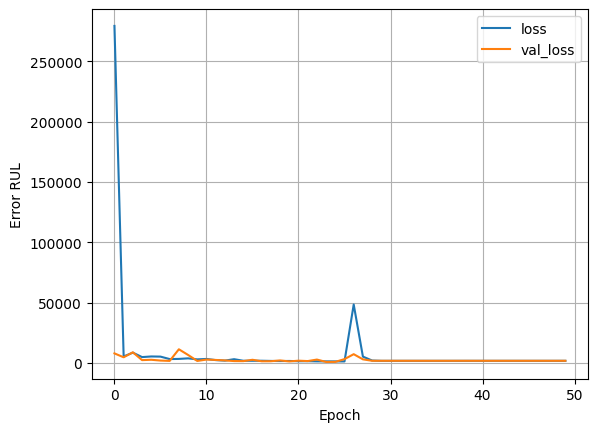

In [145]:
plot_loss(history)
plt.show()

In [120]:
model.predict(X_test[:10])

1/1 [==============================] - 0s 54ms/step


array([[78.94624],
       [78.94624],
       [78.94624],
       [78.94624],
       [78.94624],
       [78.94624],
       [78.94624],
       [78.94624],
       [78.94624],
       [78.94624]], dtype=float32)

In [133]:
X_train.head()

,machine_number,uptime,sensor_02,sensor_03,sensor_04,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,...,sensor_08_tm30,sensor_09_tm30,sensor_11_tm30,sensor_12_tm30,sensor_13_tm30,sensor_14_tm30,sensor_15_tm30,sensor_17_tm30,sensor_20_tm30,sensor_21_tm30
0,1,31,642.02,1584.18,1396.90,554.13,2388.08,9058.78,47.41,521.95,...,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392.0,39.06,23.4190
1,1,32,642.33,1591.38,1400.36,554.96,2388.04,9050.97,47.25,521.92,...,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392.0,39.00,23.4236
2,1,33,642.71,1588.40,1402.43,554.61,2388.04,9047.13,47.28,521.91,...,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390.0,38.95,23.3442
3,1,34,642.54,1581.47,1400.48,554.30,2388.03,9046.46,47.47,521.70,...,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392.0,38.88,23.3739
4,1,35,642.44,1590.00,1403.00,554.30,2388.04,9045.76,47.31,521.75,...,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393.0,38.90,23.4044
